<a href="https://colab.research.google.com/github/Malik-Raheel/Trading-Strategies/blob/main/Funding_Rate_and_Liquidation_15min.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade ccxt pandas numpy scikit-learn tensorflow pandas-ta matplotlib plotly

  Using cached numpy-2.3.4-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)


In [7]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import ccxt
import logging
import time
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Initialize Exchange
exchange = ccxt.kucoin({
    'rateLimit': 100,
    'enableRateLimit': True,
    'timeout': 30000,
})

class ProfessionalTradingStrategy:
    def __init__(self):
        self.portfolio = {}
        self.trade_log = []

    def fetch_multi_timeframe_data(self, symbol):
        """Fetch data for all timeframes with proper error handling."""
        timeframes = {
            '1W': '1w',
            '1D': '1d',
            '4H': '4h',
            '1H': '1h',
            '15M': '15m',
            '5M': '5m',
            '3M': '3m'
        }

        data = {}
        for tf_name, tf_code in timeframes.items():
            try:
                limit = 500 if tf_name in ['1W', '1D'] else 200
                df = self.fetch_historical_data(symbol, tf_code, limit)
                if not df.empty:
                    df = self.add_advanced_indicators(df)
                    data[tf_name] = df
                time.sleep(0.1)  # Rate limiting
            except Exception as e:
                logging.warning(f"Error fetching {tf_name} data for {symbol}: {e}")
                continue

        return data

    def fetch_historical_data(self, symbol, timeframe, limit=500):
        """Fetch OHLCV data with robust error handling."""
        try:
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe, limit=limit)
            if not ohlcv:
                return pd.DataFrame()

            df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            df.set_index('timestamp', inplace=True)
            df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
            return df
        except Exception as e:
            logging.error(f"Error fetching {timeframe} data for {symbol}: {e}")
            return pd.DataFrame()

    def add_advanced_indicators(self, df):
        """Add comprehensive technical indicators with safe calculations."""
        if df.empty:
            return df

        try:
            # Trend indicators
            df['EMA_9'] = ta.ema(df['close'], length=9)
            df['EMA_21'] = ta.ema(df['close'], length=21)
            df['EMA_50'] = ta.ema(df['close'], length=50)
            df['EMA_100'] = ta.ema(df['close'], length=100)
            df['SMA_20'] = ta.sma(df['close'], length=20)
            df['SMA_50'] = ta.sma(df['close'], length=50)

            # Momentum indicators
            df['RSI'] = ta.rsi(df['close'], length=14)
            df['RSI_SMA'] = ta.sma(df['RSI'], length=5) if df['RSI'].notna().any() else np.nan
            macd_data = ta.macd(df['close'])
            if macd_data is not None:
                df['MACD'] = macd_data.get('MACD_12_26_9', np.nan)
                df['MACD_Signal'] = macd_data.get('MACDs_12_26_9', np.nan)
                df['MACD_Histogram'] = macd_data.get('MACDh_12_26_9', np.nan)
            else:
                df['MACD'] = df['MACD_Signal'] = df['MACD_Histogram'] = np.nan

            # Volatility indicators
            df['ATR'] = ta.atr(df['high'], df['low'], df['close'], length=14)
            bb_data = ta.bbands(df['close'], length=20)
            if bb_data is not None:
                df['BB_upper'] = bb_data.get('BBU_20_2.0', np.nan)
                df['BB_middle'] = bb_data.get('BBM_20_2.0', np.nan)
                df['BB_lower'] = bb_data.get('BBL_20_2.0', np.nan)
            else:
                df['BB_upper'] = df['BB_middle'] = df['BB_lower'] = np.nan

            # Calculate BB metrics safely
            if pd.notna(df['BB_upper']).any() and pd.notna(df['BB_lower']).any():
                df['BB_width'] = (df['BB_upper'] - df['BB_lower']) / df['BB_middle']
                df['BB_position'] = (df['close'] - df['BB_lower']) / (df['BB_upper'] - df['BB_lower'])
            else:
                df['BB_width'] = df['BB_position'] = np.nan

            # Volume indicators
            df['OBV'] = ta.obv(df['close'], df['volume'])
            df['VWAP'] = ta.vwap(df['high'], df['low'], df['close'], df['volume'])
            df['MFI'] = ta.mfi(df['high'], df['low'], df['close'], df['volume'], length=14)

            # Support/Resistance
            df['pivot'] = (df['high'] + df['low'] + df['close']) / 3
            df['resistance'] = 2 * df['pivot'] - df['low']
            df['support'] = 2 * df['pivot'] - df['high']

            return df
        except Exception as e:
            logging.error(f"Error adding indicators: {e}")
            return df

    def analyze_multi_timeframe_trend(self, data):
        """Analyze trend across all timeframes with strength scoring."""
        trend_analysis = {}

        for tf, df in data.items():
            if df.empty or len(df) < 50:
                continue

            try:
                current_price = df['close'].iloc[-1]

                # Check if required indicators exist
                required_columns = ['EMA_9', 'EMA_21', 'EMA_50', 'EMA_100', 'RSI', 'MACD', 'MACD_Signal']
                if not all(col in df.columns for col in required_columns):
                    continue

                if any(pd.isna(df[col].iloc[-1]) for col in required_columns):
                    continue

                # EMA Alignment Analysis
                ema_9 = df['EMA_9'].iloc[-1]
                ema_21 = df['EMA_21'].iloc[-1]
                ema_50 = df['EMA_50'].iloc[-1]
                ema_100 = df['EMA_100'].iloc[-1]

                # Trend Strength Calculation
                bullish_conditions = 0
                bearish_conditions = 0

                # EMA Alignment
                if ema_9 > ema_21 > ema_50 > ema_100:
                    bullish_conditions += 3
                elif ema_9 < ema_21 < ema_50 < ema_100:
                    bearish_conditions += 3
                elif ema_9 > ema_21 and ema_21 > ema_50:
                    bullish_conditions += 2
                elif ema_9 < ema_21 and ema_21 < ema_50:
                    bearish_conditions += 2

                # Price vs EMA
                if current_price > ema_50:
                    bullish_conditions += 1
                else:
                    bearish_conditions += 1

                if current_price > ema_21:
                    bullish_conditions += 1
                else:
                    bearish_conditions += 1

                # RSI Trend
                rsi = df['RSI'].iloc[-1]
                if 50 < rsi < 70:
                    bullish_conditions += 1
                elif 30 < rsi < 50:
                    bearish_conditions += 1
                elif rsi > 70:
                    bullish_conditions -= 1  # Overbought
                elif rsi < 30:
                    bearish_conditions -= 1  # Oversold

                # MACD Trend
                macd = df['MACD'].iloc[-1]
                macd_signal = df['MACD_Signal'].iloc[-1]
                if macd > macd_signal:
                    bullish_conditions += 1
                else:
                    bearish_conditions += 1

                # Determine trend
                if bullish_conditions > bearish_conditions + 2:
                    trend = "STRONG_BULLISH"
                    strength = min(100, bullish_conditions * 15)
                elif bullish_conditions > bearish_conditions:
                    trend = "BULLISH"
                    strength = min(80, bullish_conditions * 12)
                elif bearish_conditions > bullish_conditions + 2:
                    trend = "STRONG_BEARISH"
                    strength = min(100, bearish_conditions * 15)
                elif bearish_conditions > bullish_conditions:
                    trend = "BEARISH"
                    strength = min(80, bearish_conditions * 12)
                else:
                    trend = "NEUTRAL"
                    strength = 50

                trend_analysis[tf] = {
                    'trend': trend,
                    'strength': strength,
                    'price': current_price,
                    'rsi': rsi,
                    'bullish_conditions': bullish_conditions,
                    'bearish_conditions': bearish_conditions
                }

            except Exception as e:
                logging.warning(f"Error analyzing {tf} trend: {e}")
                continue

        return trend_analysis

    def get_trading_timeframe_signals(self, data):
        """Get trading signals for 15M, 5M, 3M timeframes."""
        trading_signals = {}

        for tf in ['15M', '5M', '3M']:
            if tf not in data or data[tf].empty or len(data[tf]) < 20:
                continue

            try:
                df = data[tf]
                current_price = df['close'].iloc[-1]
                signals = []

                # Check if required indicators exist
                required_indicators = ['RSI', 'MACD', 'MACD_Signal', 'BB_position', 'EMA_9', 'EMA_21']
                if not all(col in df.columns for col in required_indicators):
                    continue

                # RSI Signals
                rsi = df['RSI'].iloc[-1]
                if pd.notna(rsi) and len(df) > 1:
                    if rsi < 30 and df['RSI'].iloc[-2] < rsi:
                        signals.append(('RSI_OVERSOLD_BOUNCE', 'LONG', 0.8))
                    elif rsi > 70 and df['RSI'].iloc[-2] > rsi:
                        signals.append(('RSI_OVERBOUGHT_REVERSAL', 'SHORT', 0.8))
                    elif 30 < rsi < 40 and df['RSI'].iloc[-1] > df['RSI'].iloc[-2]:
                        signals.append(('RSI_BULLISH_MOMENTUM', 'LONG', 0.7))
                    elif 60 < rsi < 70 and df['RSI'].iloc[-1] < df['RSI'].iloc[-2]:
                        signals.append(('RSI_BEARISH_MOMENTUM', 'SHORT', 0.7))

                # MACD Signals
                macd = df['MACD'].iloc[-1]
                macd_signal = df['MACD_Signal'].iloc[-1]
                if pd.notna(macd) and pd.notna(macd_signal) and len(df) > 1:
                    if macd > macd_signal and df['MACD'].iloc[-2] <= df['MACD_Signal'].iloc[-2]:
                        signals.append(('MACD_BULLISH_CROSS', 'LONG', 0.9))
                    elif macd < macd_signal and df['MACD'].iloc[-2] >= df['MACD_Signal'].iloc[-2]:
                        signals.append(('MACD_BEARISH_CROSS', 'SHORT', 0.9))

                # Bollinger Bands Signals
                bb_position = df['BB_position'].iloc[-1] if 'BB_position' in df.columns else 0.5
                if pd.notna(bb_position):
                    if bb_position < 0.1 and current_price > df['BB_lower'].iloc[-1]:
                        signals.append(('BB_OVERSOLD_BOUNCE', 'LONG', 0.8))
                    elif bb_position > 0.9 and current_price < df['BB_upper'].iloc[-1]:
                        signals.append(('BB_OVERBOUGHT_REVERSAL', 'SHORT', 0.8))
                    elif bb_position > 0.5 and current_price > df['BB_middle'].iloc[-1]:
                        signals.append(('BB_BULLISH_TREND', 'LONG', 0.6))
                    elif bb_position < 0.5 and current_price < df['BB_middle'].iloc[-1]:
                        signals.append(('BB_BEARISH_TREND', 'SHORT', 0.6))

                # EMA Signals
                ema_9 = df['EMA_9'].iloc[-1]
                ema_21 = df['EMA_21'].iloc[-1]
                if pd.notna(ema_9) and pd.notna(ema_21) and len(df) > 1:
                    if (current_price > ema_9 > ema_21 and
                        df['EMA_9'].iloc[-1] > df['EMA_9'].iloc[-2]):
                        signals.append(('EMA_BULLISH_ALIGNMENT', 'LONG', 0.7))
                    elif (current_price < ema_9 < ema_21 and
                          df['EMA_9'].iloc[-1] < df['EMA_9'].iloc[-2]):
                        signals.append(('EMA_BEARISH_ALIGNMENT', 'SHORT', 0.7))

                trading_signals[tf] = {
                    'signals': signals,
                    'best_signal': max(signals, key=lambda x: x[2]) if signals else None,
                    'current_price': current_price,
                    'rsi': rsi,
                    'macd_histogram': df['MACD_Histogram'].iloc[-1] if 'MACD_Histogram' in df.columns else 0,
                    'bb_position': bb_position
                }

            except Exception as e:
                logging.warning(f"Error getting {tf} signals: {e}")
                continue

        return trading_signals

    def fetch_funding_metrics(self, symbol):
        """Fetch funding rate with trend analysis."""
        try:
            # Try different symbol formats
            symbol_clean = symbol.replace('/', '')
            markets = exchange.load_markets()

            # Look for perpetual contract
            for market_symbol in markets:
                if symbol_clean in market_symbol and ('PERP' in market_symbol or 'USDT' in market_symbol):
                    try:
                        funding_data = exchange.fetch_funding_rate(market_symbol)
                        if funding_data:
                            funding_rate = funding_data['fundingRate']

                            # Funding rate grading
                            if funding_rate < -0.0005:
                                grade = 'A+'  # Strong long bias
                                bias = 'STRONG_LONG'
                            elif funding_rate < -0.0001:
                                grade = 'A'   # Moderate long bias
                                bias = 'LONG'
                            elif funding_rate > 0.0005:
                                grade = 'A+'  # Strong short bias
                                bias = 'STRONG_SHORT'
                            elif funding_rate > 0.0001:
                                grade = 'A'   # Moderate short bias
                                bias = 'SHORT'
                            else:
                                grade = 'B'   # Neutral
                                bias = 'NEUTRAL'

                            return {
                                'rate': funding_rate,
                                'grade': grade,
                                'bias': bias,
                                'next_funding': funding_data.get('nextFundingTime')
                            }
                    except:
                        continue

            return None
        except Exception as e:
            logging.warning(f"Funding data unavailable for {symbol}: {e}")
            return None

    def analyze_liquidation_zones(self, symbol, current_price, atr):
        """Analyze liquidation zones with grading."""
        try:
            order_book = exchange.fetch_order_book(symbol, limit=100)
            bids = order_book['bids']
            asks = order_book['asks']

            if not bids or not asks:
                return None

            # Find significant liquidity levels
            significant_bids = [bid for bid in bids if bid[1] > 5000]
            significant_asks = [ask for ask in asks if ask[1] > 5000]

            if not significant_bids or not significant_asks:
                return None

            # Liquidation zones
            short_liq_zone = max([bid[0] for bid in significant_bids])
            long_liq_zone = min([ask[0] for ask in significant_asks])

            # Distance calculations
            dist_to_short_liq = abs(current_price - short_liq_zone) / current_price * 100
            dist_to_long_liq = abs(current_price - long_liq_zone) / current_price * 100

            # Liquidation grading
            if dist_to_short_liq < 1.0 or dist_to_long_liq < 1.0:
                grade = 'A+'  # Very close to liquidation
            elif dist_to_short_liq < 2.0 or dist_to_long_liq < 2.0:
                grade = 'A'   # Close to liquidation
            elif dist_to_short_liq < 3.0 or dist_to_long_liq < 3.0:
                grade = 'B+'  # Moderate distance
            elif dist_to_short_liq < 5.0 or dist_to_long_liq < 5.0:
                grade = 'B'   # Reasonable distance
            else:
                grade = 'C'   # Far from liquidations

            return {
                'short_liq_price': short_liq_zone,
                'long_liq_price': long_liq_zone,
                'dist_to_short_liq': dist_to_short_liq,
                'dist_to_long_liq': dist_to_long_liq,
                'grade': grade,
                'liquidation_clusters': len(significant_bids) + len(significant_asks)
            }
        except Exception as e:
            logging.warning(f"Liquidation analysis failed for {symbol}: {e}")
            return None

    def calculate_overall_grade(self, trend_analysis, trading_signals, funding_data, liquidation_data):
        """Calculate overall trade grade A+ to C."""
        grades = []

        # Multi-timeframe trend alignment (40% weight)
        trend_score = 0
        trend_count = 0
        for tf in ['1W', '1D', '4H']:
            if tf in trend_analysis:
                trend = trend_analysis[tf]['trend']
                if 'BULLISH' in trend:
                    trend_score += 1
                elif 'BEARISH' in trend:
                    trend_score -= 1
                trend_count += 1

        if trend_count > 0:
            trend_alignment = trend_score / trend_count
            if abs(trend_alignment) > 0.7:
                grades.append('A+')
            elif abs(trend_alignment) > 0.5:
                grades.append('A')
            elif abs(trend_alignment) > 0.3:
                grades.append('B+')
            else:
                grades.append('C')

        # Trading signals strength (30% weight)
        signal_strength = 0
        signal_count = 0
        for tf in ['15M', '5M', '3M']:
            if tf in trading_signals and trading_signals[tf]['best_signal']:
                signal_strength += trading_signals[tf]['best_signal'][2]  # Confidence
                signal_count += 1

        if signal_count > 0:
            avg_signal_strength = signal_strength / signal_count
            if avg_signal_strength > 0.8:
                grades.append('A+')
            elif avg_signal_strength > 0.7:
                grades.append('A')
            elif avg_signal_strength > 0.6:
                grades.append('B+')
            else:
                grades.append('C')
        else:
            grades.append('C')

        # Funding rate alignment (15% weight)
        if funding_data:
            grades.append(funding_data['grade'])
        else:
            grades.append('C')

        # Liquidation alignment (15% weight)
        if liquidation_data:
            grades.append(liquidation_data['grade'])
        else:
            grades.append('C')

        # Calculate final grade
        grade_scores = {'A+': 4, 'A': 3, 'B+': 2, 'B': 1, 'C': 0}
        total_score = sum(grade_scores.get(g, 0) for g in grades)
        avg_score = total_score / len(grades) if grades else 0

        if avg_score >= 3.5:
            return 'A+'
        elif avg_score >= 2.5:
            return 'A'
        elif avg_score >= 1.5:
            return 'B+'
        elif avg_score >= 0.5:
            return 'B'
        else:
            return 'C'

    def generate_trading_decision(self, symbol, data, trend_analysis, trading_signals, funding_data, liquidation_data):
        """Generate final trading decision."""
        # Get best trading timeframe signal
        best_tf = None
        best_signal = None
        for tf in ['15M', '5M', '3M']:
            if tf in trading_signals and trading_signals[tf]['best_signal']:
                if best_signal is None or trading_signals[tf]['best_signal'][2] > best_signal[2]:
                    best_signal = trading_signals[tf]['best_signal']
                    best_tf = tf

        if not best_signal:
            return {
                'action': 'HOLD',
                'reason': 'No clear signals',
                'grade': 'C'
            }

        signal_type, direction, confidence = best_signal
        current_price = trading_signals[best_tf]['current_price']

        # Get ATR for risk management
        atr = data[best_tf]['ATR'].iloc[-1] if best_tf in data and 'ATR' in data[best_tf] else current_price * 0.01

        # Calculate stop loss and take profit
        if direction == 'LONG':
            stop_loss = current_price - (atr * 1.5)
            take_profit = current_price + (atr * 3)
            # Adjust for liquidation zones
            if liquidation_data:
                stop_loss = min(stop_loss, liquidation_data['short_liq_price'] * 0.995)
        else:
            stop_loss = current_price + (atr * 1.5)
            take_profit = current_price - (atr * 3)
            if liquidation_data:
                stop_loss = max(stop_loss, liquidation_data['long_liq_price'] * 1.005)

        # Risk-reward check
        risk_amount = abs(current_price - stop_loss)
        if risk_amount == 0:
            return {
                'action': 'HOLD',
                'reason': 'Invalid risk calculation',
                'grade': 'C'
            }

        risk_reward = abs(take_profit - current_price) / risk_amount

        if risk_reward < 1.5:
            return {
                'action': 'HOLD',
                'reason': f'Poor R:R {risk_reward:.2f}',
                'grade': 'C'
            }

        # Calculate overall grade
        overall_grade = self.calculate_overall_grade(trend_analysis, trading_signals, funding_data, liquidation_data)

        return {
            'action': direction,
            'entry_type': signal_type,
            'timeframe': best_tf,
            'entry_price': current_price,
            'stop_loss': stop_loss,
            'take_profit': take_profit,
            'risk_reward': risk_reward,
            'confidence': confidence,
            'grade': overall_grade
        }

    def analyze_asset(self, symbol):
        """Complete professional analysis."""
        try:
            print(f"\n🎯 {symbol} - PROFESSIONAL ANALYSIS")
            print("=" * 80)

            # Fetch all data
            data = self.fetch_multi_timeframe_data(symbol)
            if not data:
                print("❌ No data available - Check API connection or symbol")
                return

            # Multi-timeframe trend analysis
            trend_analysis = self.analyze_multi_timeframe_trend(data)

            # Trading timeframe signals
            trading_signals = self.get_trading_timeframe_signals(data)

            # Market data
            current_price = data['15M']['close'].iloc[-1] if '15M' in data else 0
            funding_data = self.fetch_funding_metrics(symbol)
            liquidation_data = self.analyze_liquidation_zones(symbol, current_price,
                                                            data['15M']['ATR'].iloc[-1] if '15M' in data else 0.01)

            # Generate decision
            decision = self.generate_trading_decision(symbol, data, trend_analysis,
                                                    trading_signals, funding_data, liquidation_data)

            # Display results
            self.display_comprehensive_analysis(symbol, trend_analysis, trading_signals,
                                              funding_data, liquidation_data, decision)

        except Exception as e:
            logging.error(f"Analysis error for {symbol}: {e}")
            print(f"❌ Analysis failed: {e}")

    def display_comprehensive_analysis(self, symbol, trend_analysis, trading_signals,
                                     funding_data, liquidation_data, decision):
        """Display professional analysis results."""

        # Multi-timeframe Trends
        print("\n📊 MULTI-TIMEFRAME TREND ANALYSIS:")
        print("-" * 50)
        for tf in ['1W', '1D', '4H', '1H']:
            if tf in trend_analysis:
                ta = trend_analysis[tf]
                trend_emoji = "🟢" if "BULL" in ta['trend'] else "🔴" if "BEAR" in ta['trend'] else "🟡"
                print(f"   {tf}: {trend_emoji} {ta['trend']:15} | Strength: {ta['strength']:3.0f}% | RSI: {ta['rsi']:5.1f}")
            else:
                print(f"   {tf}: ❌ No data")

        # Trading Timeframe Signals
        print("\n🎯 TRADING TIMEFRAME SIGNALS:")
        print("-" * 50)
        for tf in ['15M', '5M', '3M']:
            if tf in trading_signals and trading_signals[tf]['signals']:
                ts = trading_signals[tf]
                best_signal = ts['best_signal']
                signal_emoji = "🟢" if best_signal[1] == 'LONG' else "🔴"
                print(f"   {tf}: {signal_emoji} {best_signal[1]:6} | {best_signal[0]:25} | Conf: {best_signal[2]:.1%}")
            else:
                print(f"   {tf}: ❌ No signals")

        # Market Data
        print("\n💰 MARKET DATA:")
        print("-" * 50)
        if funding_data:
            fr_emoji = "🟢" if funding_data['bias'] in ['STRONG_LONG', 'LONG'] else "🔴" if funding_data['bias'] in ['STRONG_SHORT', 'SHORT'] else "🟡"
            print(f"   Funding: {fr_emoji} {funding_data['rate']:.6f} | Grade: {funding_data['grade']} | Bias: {funding_data['bias']}")
        else:
            print(f"   Funding: ❌ No data")

        if liquidation_data:
            liq_emoji = "🔴" if liquidation_data['grade'] in ['A+', 'A'] else "🟡" if liquidation_data['grade'] == 'B+' else "🟢"
            print(f"   Liquidation: {liq_emoji} Short: ${liquidation_data['short_liq_price']:.4f} | Long: ${liquidation_data['long_liq_price']:.4f}")
            print(f"   Liq Distance: Short({liquidation_data['dist_to_short_liq']:.2f}%) | Long({liquidation_data['dist_to_long_liq']:.2f}%) | Grade: {liquidation_data['grade']}")
        else:
            print(f"   Liquidation: ❌ No data")

        # Trading Decision
        print("\n🚀 TRADING DECISION:")
        print("-" * 50)
        grade_emoji = "🟢" if decision['grade'] in ['A+', 'A'] else "🟡" if decision['grade'] in ['B+', 'B'] else "🔴"

        if decision['action'] in ['LONG', 'SHORT']:
            action_emoji = "🟢" if decision['action'] == 'LONG' else "🔴"
            print(f"   ACTION: {action_emoji} {decision['action']} | Grade: {grade_emoji} {decision['grade']}")
            print(f"   Timeframe: {decision['timeframe']} | Signal: {decision['entry_type']}")
            print(f"   Entry: ${decision['entry_price']:.4f} | Stop: ${decision['stop_loss']:.4f}")
            print(f"   Target: ${decision['take_profit']:.4f} | R:R: {decision['risk_reward']:.2f}:1")
            print(f"   Confidence: {decision['confidence']:.1%}")
        else:
            print(f"   ACTION: 🟡 {decision['action']} | Grade: {grade_emoji} {decision['grade']}")
            print(f"   Reason: {decision['reason']}")

        # Technical Summary
        if '15M' in trading_signals:
            ts = trading_signals['15M']
            print(f"\n📈 15M TECHNICALS:")
            print(f"   RSI: {ts['rsi']:.1f} | MACD Hist: {ts['macd_histogram']:.4f} | BB Pos: {ts['bb_position']:.2f}")

        print("=" * 80)

# Main execution
if __name__ == "__main__":
    strategy = ProfessionalTradingStrategy()

    assets = ['BTC/USDT', 'ETH/USDT', 'ADA/USDT', 'SOL/USDT', 'XRP/USDT']

    print("🚀 PROFESSIONAL DAY TRADING STRATEGY - MULTI TIMEFRAME ANALYSIS")
    print("=" * 80)

    for asset in assets:
        strategy.analyze_asset(asset)
        time.sleep(1)  # Rate limiting between symbols

    print("\n" + "=" * 80)
    print("✅ ALL ANALYSES COMPLETE - READY FOR TRADING!")

🚀 PROFESSIONAL DAY TRADING STRATEGY - MULTI TIMEFRAME ANALYSIS

🎯 BTC/USDT - PROFESSIONAL ANALYSIS

📊 MULTI-TIMEFRAME TREND ANALYSIS:
--------------------------------------------------
   1W: 🟢 BULLISH         | Strength:  48% | RSI:  48.9
   1D: 🔴 STRONG_BEARISH  | Strength:  90% | RSI:  40.5
   4H: 🔴 STRONG_BEARISH  | Strength: 100% | RSI:  46.1
   1H: 🔴 STRONG_BEARISH  | Strength:  90% | RSI:  44.7

🎯 TRADING TIMEFRAME SIGNALS:
--------------------------------------------------
   15M: ❌ No signals
   5M: ❌ No signals
   3M: 🔴 SHORT  | MACD_BEARISH_CROSS        | Conf: 90.0%

💰 MARKET DATA:
--------------------------------------------------
   Funding: ❌ No data
   Liquidation: ❌ No data

🚀 TRADING DECISION:
--------------------------------------------------
   ACTION: 🔴 SHORT | Grade: 🟡 B+
   Timeframe: 3M | Signal: MACD_BEARISH_CROSS
   Entry: $108182.3000 | Stop: $108654.6455
   Target: $107237.6090 | R:R: 2.00:1
   Confidence: 90.0%

📈 15M TECHNICALS:
   RSI: 50.2 | MACD Hist: 4

backtestig the above strategy
it gives 17% win rate. strategy is not very strong. work to improve the strategy.

🚀 COMPREHENSIVE STRATEGY BACKTEST - REAL KUCOIN DATA

📊 Testing BTC/USDT...

🔬 BACKTESTING BTC/USDT - Last 60 Days
📊 Backtesting Period: 2025-08-23 17:00:00 to 2025-10-22 16:45:00
📈 Total Data Points: 5760
💰 Initial Capital: $10,000.00
------------------------------------------------------------

📊 BACKTEST RESULTS
📈 Total Trades: 6
✅ Win Rate: 16.7%
❌ Loss Rate: 83.3%
💰 Total PnL: $-175.76
📊 Total Return: 1.94%
🎯 Final Capital: $10,194.49
⚡ Sharpe Ratio: -7.46
📉 Max Drawdown: -49.51%
📈 Average Win: $82.36
📉 Average Loss: $-51.62
💎 Profit Factor: 0.32

🔍 TRADE ANALYSIS:
   Long Trades: 2
   Short Trades: 4
   Avg Trade Duration: 0.3 hours
   Best Trade: $82.36 (1.83%)
   Worst Trade: $-105.55 (-2.24%)

🎯 SIGNAL PERFORMANCE:
   EMA_BEARISH_ALIGNMENT: 0.0% win rate, Avg PnL: $-55.70
   RSI_OVERSOLD_BOUNCE: 100.0% win rate, Avg PnL: $82.36
   MACD_BULLISH_CROSS: 0.0% win rate, Avg PnL: $-35.31


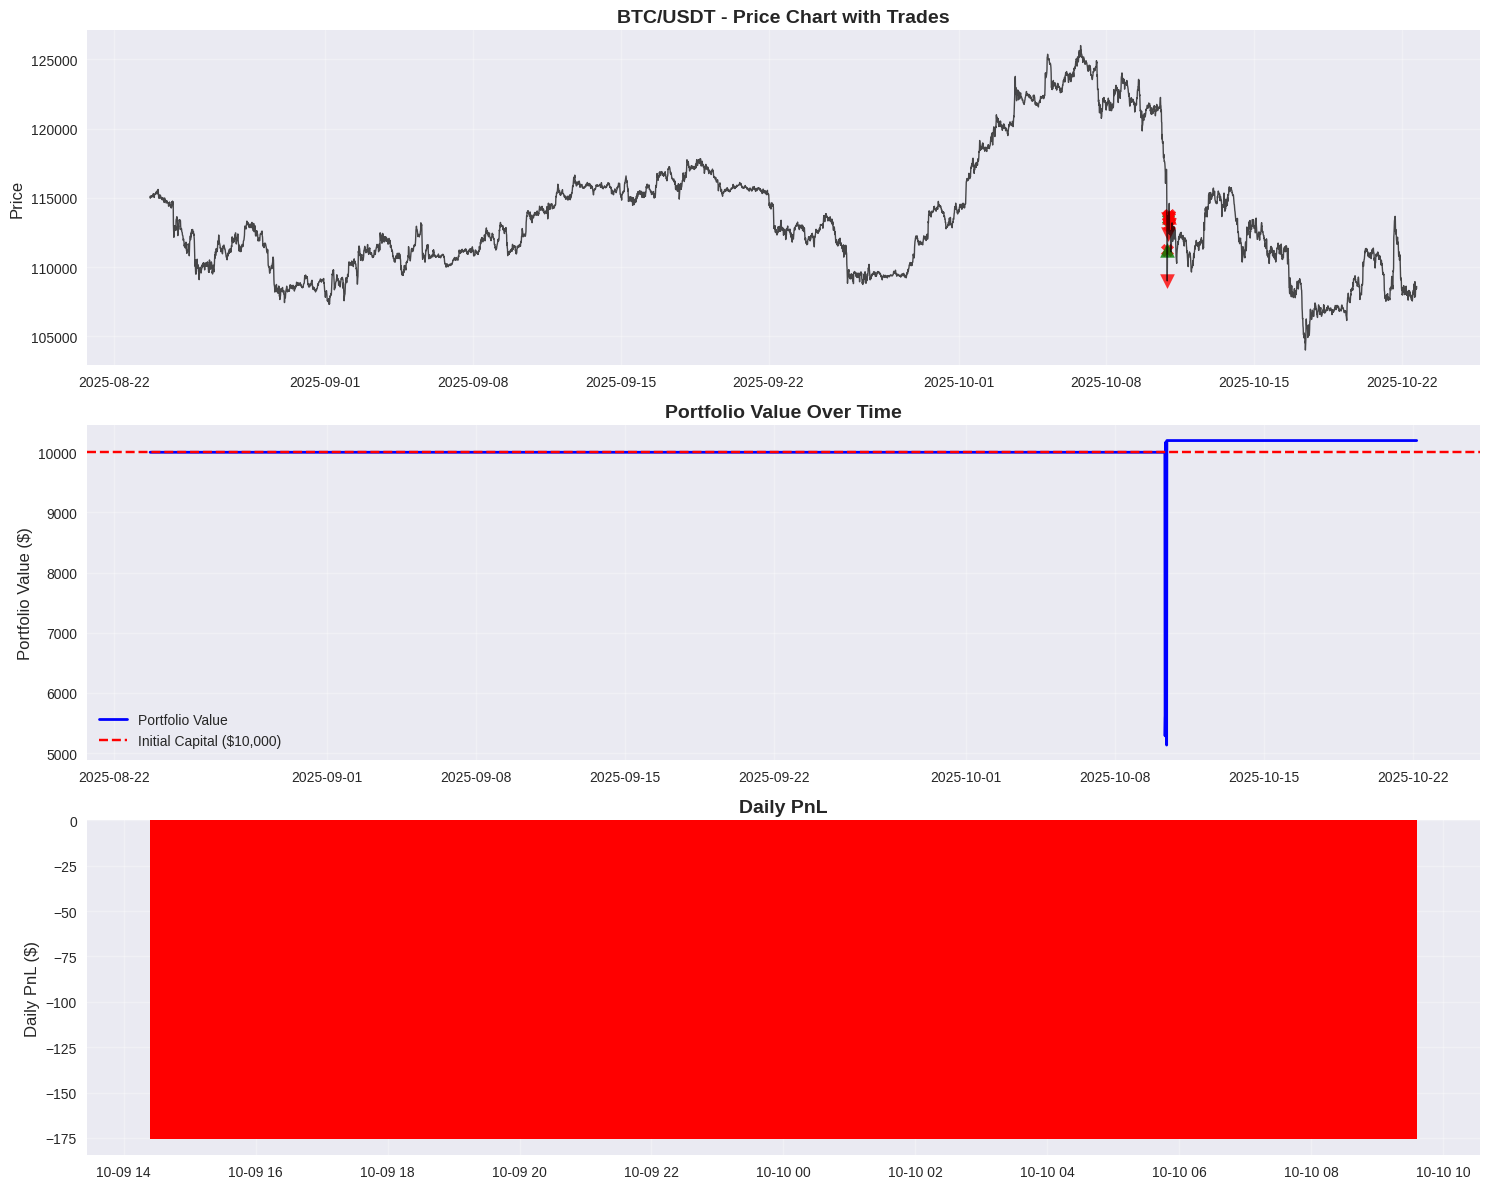


📊 Testing ETH/USDT...

🔬 BACKTESTING ETH/USDT - Last 60 Days
📊 Backtesting Period: 2025-08-23 17:00:00 to 2025-10-22 16:45:00
📈 Total Data Points: 5760
💰 Initial Capital: $10,000.00
------------------------------------------------------------

📊 BACKTEST RESULTS
📈 Total Trades: 10
✅ Win Rate: 30.0%
❌ Loss Rate: 70.0%
💰 Total PnL: $-135.97
📊 Total Return: 0.67%
🎯 Final Capital: $10,066.68
⚡ Sharpe Ratio: -2.22
📉 Max Drawdown: -45.62%
📈 Average Win: $94.08
📉 Average Loss: $-59.74
💎 Profit Factor: 0.67

🔍 TRADE ANALYSIS:
   Long Trades: 3
   Short Trades: 7
   Avg Trade Duration: 0.6 hours
   Best Trade: $162.85 (3.57%)
   Worst Trade: $-194.01 (-6.33%)

🎯 SIGNAL PERFORMANCE:
   EMA_BEARISH_ALIGNMENT: 28.6% win rate, Avg PnL: $-21.53
   RSI_BULLISH_MOMENTUM: 0.0% win rate, Avg PnL: $-42.19
   MACD_BULLISH_CROSS: 50.0% win rate, Avg PnL: $28.48


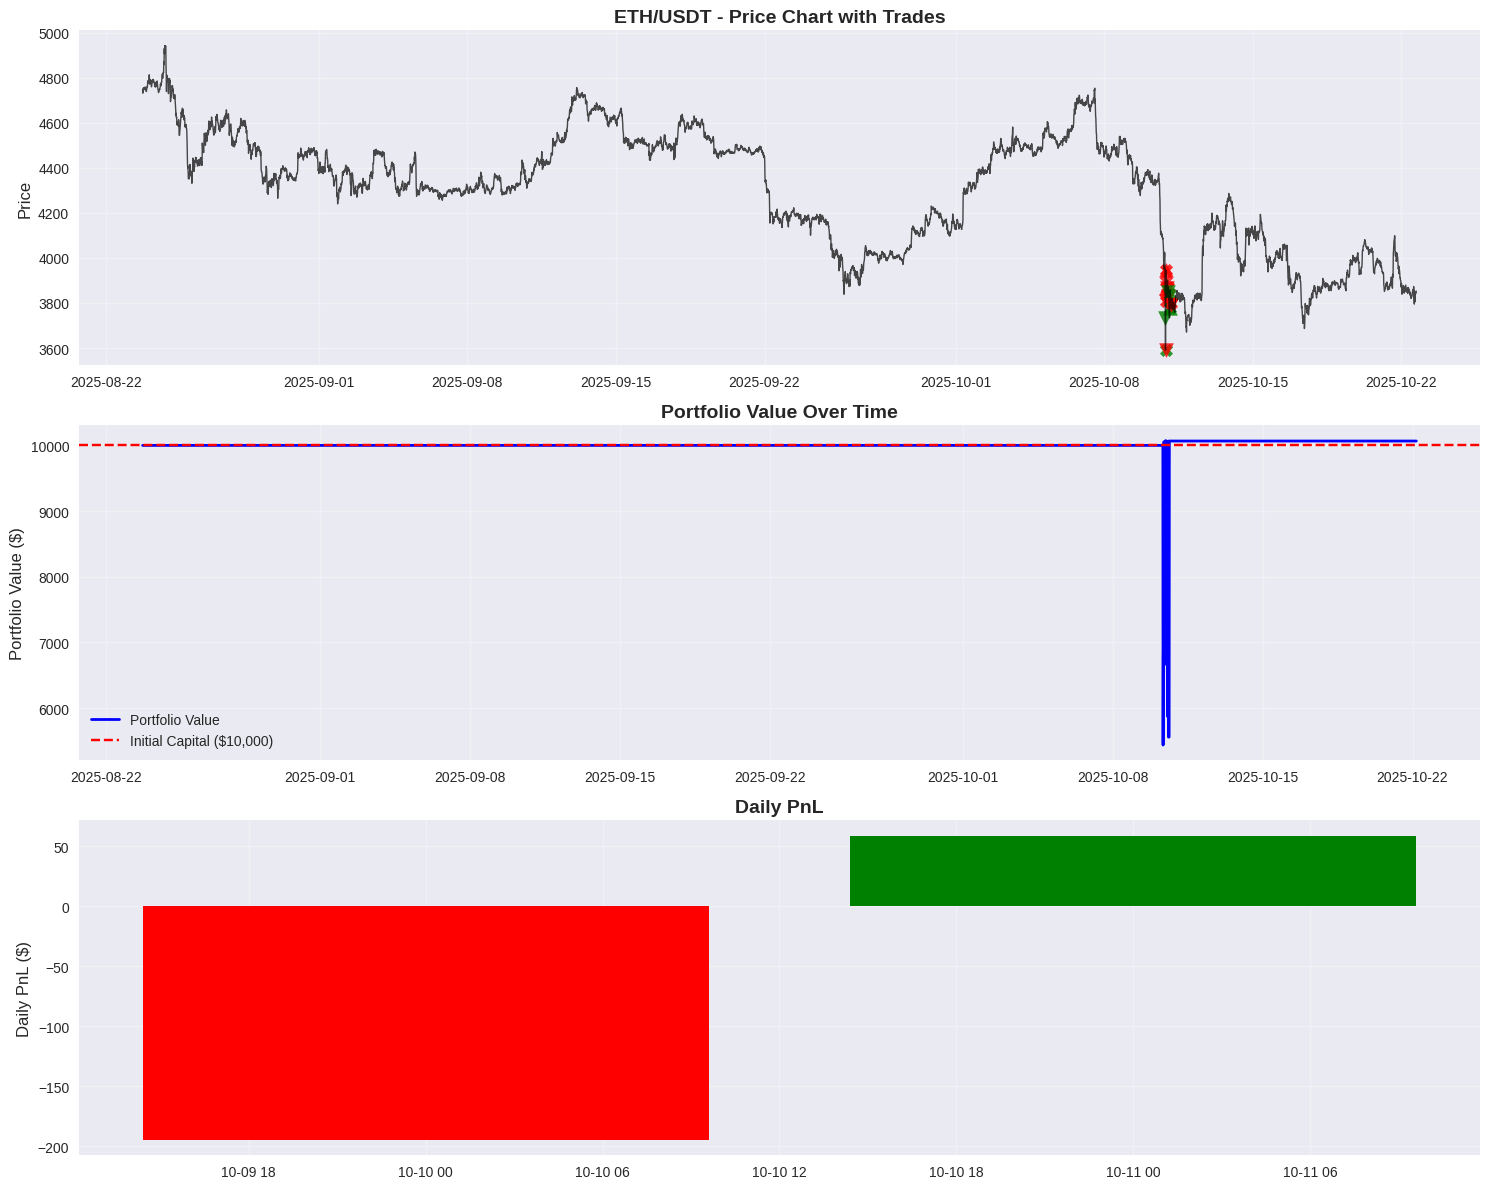


📊 Testing ADA/USDT...

🔬 BACKTESTING ADA/USDT - Last 60 Days
📊 Backtesting Period: 2025-08-23 17:00:00 to 2025-10-22 16:45:00
📈 Total Data Points: 5760
💰 Initial Capital: $10,000.00
------------------------------------------------------------

📊 BACKTEST RESULTS
📈 Total Trades: 17
✅ Win Rate: 17.6%
❌ Loss Rate: 82.4%
💰 Total PnL: $507.57
📊 Total Return: -7.90%
🎯 Final Capital: $9,209.89
⚡ Sharpe Ratio: 1.71
📉 Max Drawdown: -51.90%
📈 Average Win: $401.23
📉 Average Loss: $-49.72
💎 Profit Factor: 1.73

🔍 TRADE ANALYSIS:
   Long Trades: 7
   Short Trades: 10
   Avg Trade Duration: 0.5 hours
   Best Trade: $1070.51 (37.23%)
   Worst Trade: $-250.24 (-40.27%)

🎯 SIGNAL PERFORMANCE:
   EMA_BEARISH_ALIGNMENT: 20.0% win rate, Avg PnL: $61.46
   MACD_BULLISH_CROSS: 0.0% win rate, Avg PnL: $-13.03
   EMA_BULLISH_ALIGNMENT: 16.7% win rate, Avg PnL: $-15.66


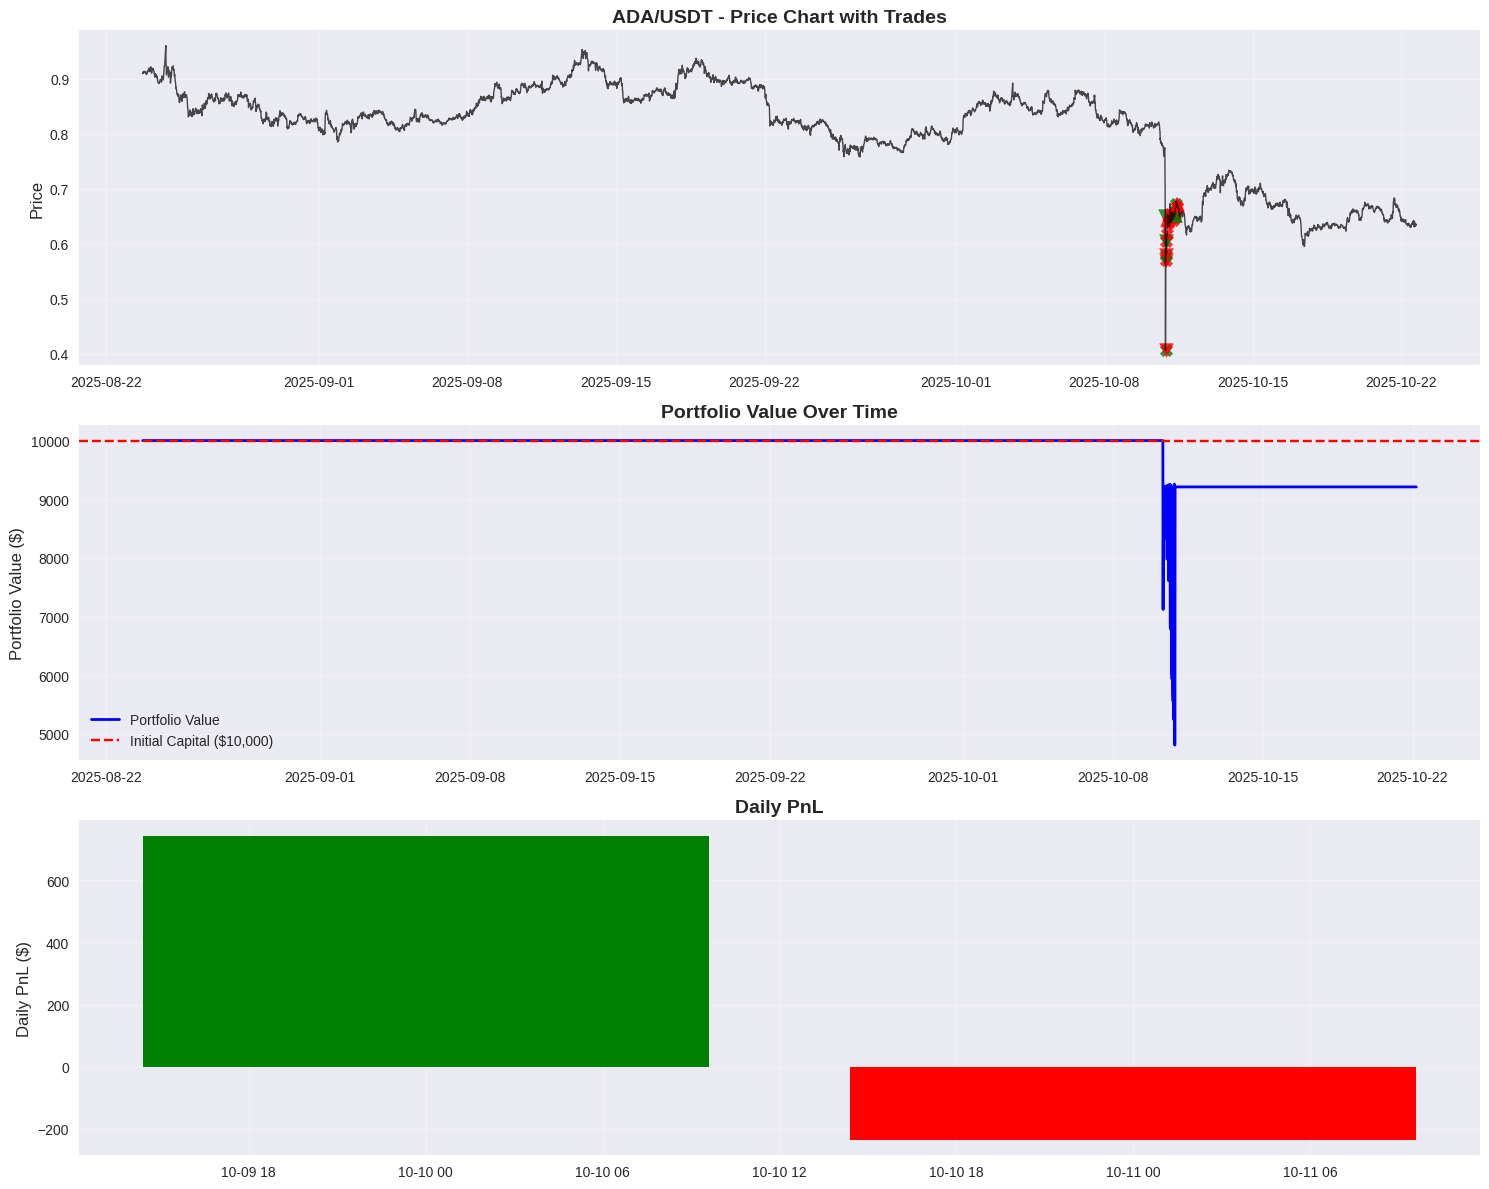


📊 Testing SOL/USDT...

🔬 BACKTESTING SOL/USDT - Last 60 Days
📊 Backtesting Period: 2025-08-23 17:00:00 to 2025-10-22 16:45:00
📈 Total Data Points: 5760
💰 Initial Capital: $10,000.00
------------------------------------------------------------

📊 BACKTEST RESULTS
📈 Total Trades: 11
✅ Win Rate: 18.2%
❌ Loss Rate: 81.8%
💰 Total PnL: $-80.64
📊 Total Return: -1.54%
🎯 Final Capital: $9,846.39
⚡ Sharpe Ratio: -0.83
📉 Max Drawdown: -45.92%
📈 Average Win: $187.89
📉 Average Loss: $-50.71
💎 Profit Factor: 0.82

🔍 TRADE ANALYSIS:
   Long Trades: 2
   Short Trades: 9
   Avg Trade Duration: 0.8 hours
   Best Trade: $355.29 (10.87%)
   Worst Trade: $-253.38 (-16.80%)

🎯 SIGNAL PERFORMANCE:
   EMA_BEARISH_ALIGNMENT: 22.2% win rate, Avg PnL: $-1.37
   RSI_BULLISH_MOMENTUM: 0.0% win rate, Avg PnL: $-31.76
   MACD_BULLISH_CROSS: 0.0% win rate, Avg PnL: $-36.59


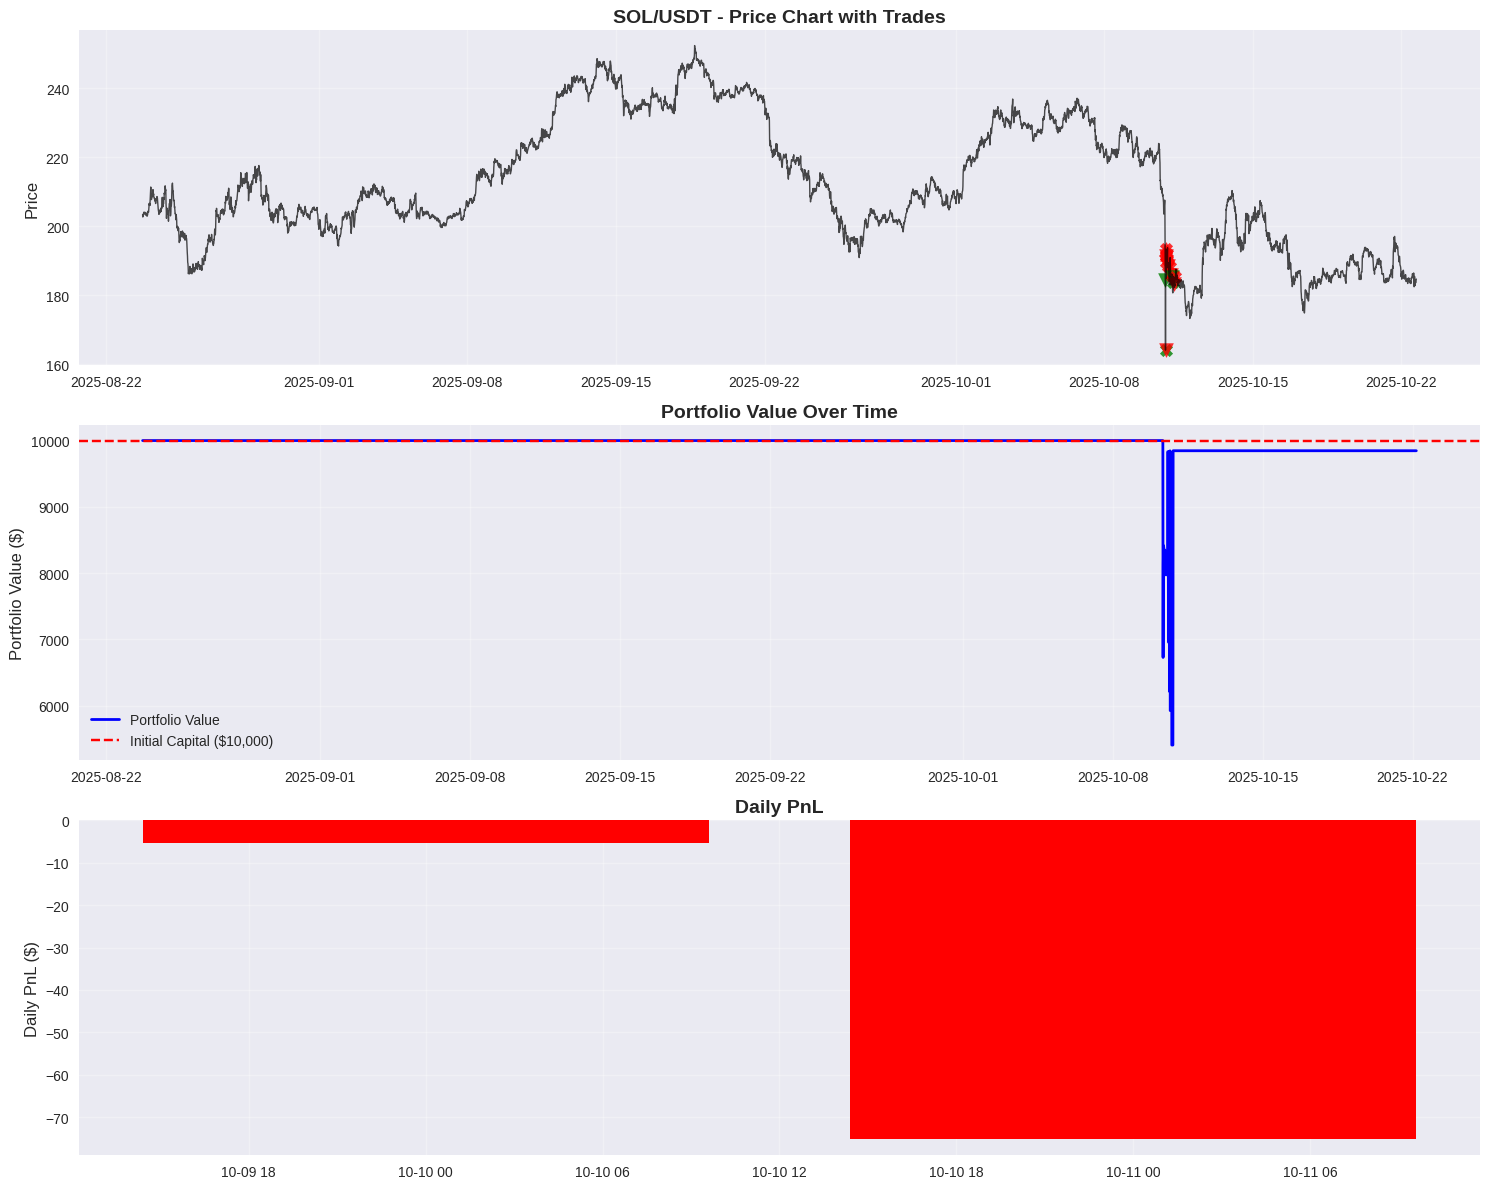


📊 Testing XRP/USDT...

🔬 BACKTESTING XRP/USDT - Last 60 Days
📊 Backtesting Period: 2025-08-23 17:00:00 to 2025-10-22 16:45:00
📈 Total Data Points: 5760
💰 Initial Capital: $10,000.00
------------------------------------------------------------

📊 BACKTEST RESULTS
📈 Total Trades: 12
✅ Win Rate: 25.0%
❌ Loss Rate: 75.0%
💰 Total PnL: $412.34
📊 Total Return: -6.20%
🎯 Final Capital: $9,380.33
⚡ Sharpe Ratio: 3.25
📉 Max Drawdown: -51.17%
📈 Average Win: $251.62
📉 Average Loss: $-38.06
💎 Profit Factor: 2.20

🔍 TRADE ANALYSIS:
   Long Trades: 4
   Short Trades: 8
   Avg Trade Duration: 0.8 hours
   Best Trade: $381.16 (15.02%)
   Worst Trade: $-201.79 (-22.25%)

🎯 SIGNAL PERFORMANCE:
   MACD_BEARISH_CROSS: 100.0% win rate, Avg PnL: $368.11
   EMA_BEARISH_ALIGNMENT: 14.3% win rate, Avg PnL: $16.79
   MACD_BULLISH_CROSS: 0.0% win rate, Avg PnL: $-9.82
   EMA_BULLISH_ALIGNMENT: 33.3% win rate, Avg PnL: $-21.15


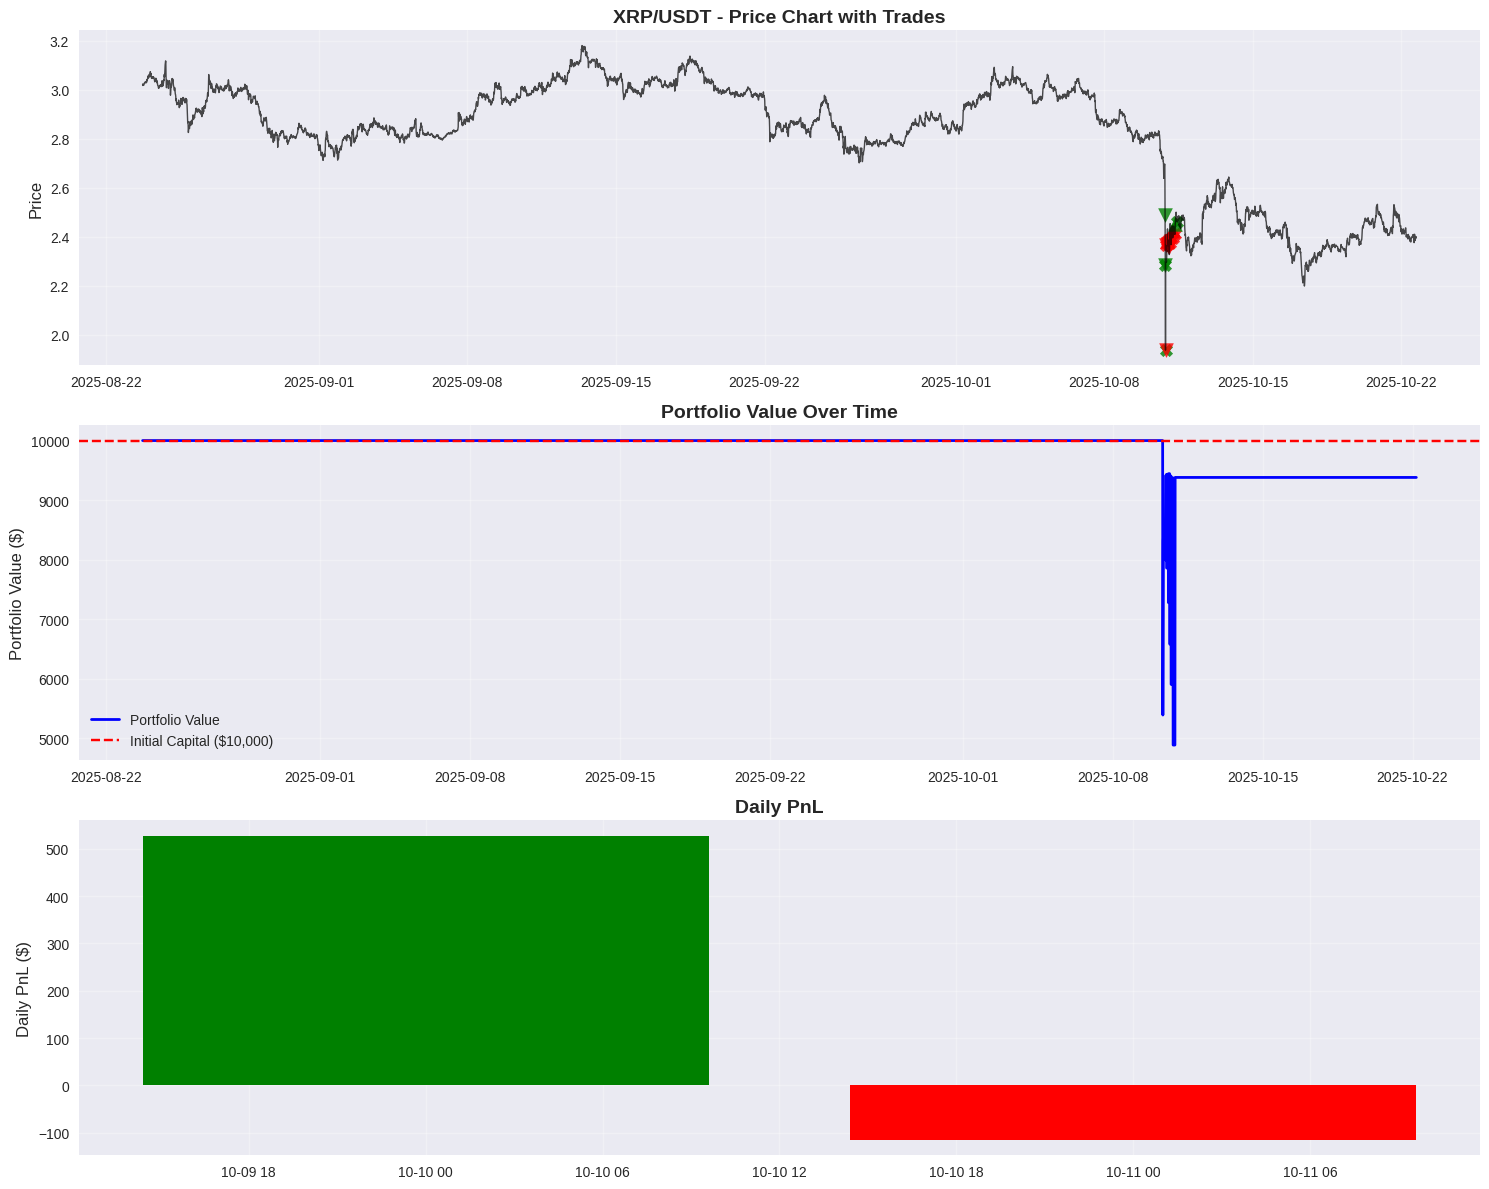


🎯 PORTFOLIO BACKTEST SUMMARY
📊 Total Symbols Tested: 5
📈 Total Trades: 56
✅ Portfolio Win Rate: 21.4%
💰 Total Portfolio PnL: $527.53
📊 Total Portfolio Return: 5.28%
🎯 Final Portfolio Value: $10,527.53

🔍 INDIVIDUAL SYMBOL PERFORMANCE:
   BTC/USDT: ❌ PnL: $-175.76 | Return: 1.94% | Win Rate: 16.7% | Trades: 6
   ETH/USDT: ❌ PnL: $-135.97 | Return: 0.67% | Win Rate: 30.0% | Trades: 10
   ADA/USDT: ✅ PnL: $507.57 | Return: -7.90% | Win Rate: 17.6% | Trades: 17
   SOL/USDT: ❌ PnL: $-80.64 | Return: -1.54% | Win Rate: 18.2% | Trades: 11
   XRP/USDT: ✅ PnL: $412.34 | Return: -6.20% | Win Rate: 25.0% | Trades: 12


In [10]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import ccxt
import logging
import time
from datetime import datetime, timedelta
import warnings
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Initialize Exchange
exchange = ccxt.kucoin({
    'rateLimit': 100,
    'enableRateLimit': True,
    'timeout': 30000,
})

class BacktestingEngine:
    def __init__(self, initial_capital=10000, commission=0.001):
        self.initial_capital = initial_capital
        self.current_capital = initial_capital
        self.commission = commission  # 0.1% trading commission
        self.positions = {}
        self.trade_history = []
        self.portfolio_values = []
        self.daily_pnl = []

    def calculate_metrics(self):
        """Calculate comprehensive backtesting metrics."""
        if not self.trade_history:
            return {
                'total_trades': 0,
                'win_rate': 0,
                'loss_rate': 0,
                'total_pnl': 0,
                'total_return': 0,
                'sharpe_ratio': 0,
                'max_drawdown': 0,
                'avg_win': 0,
                'avg_loss': 0,
                'profit_factor': 0
            }

        trades = pd.DataFrame(self.trade_history)

        # Basic metrics
        total_trades = len(trades)
        winning_trades = trades[trades['pnl'] > 0]
        losing_trades = trades[trades['pnl'] < 0]
        win_rate = len(winning_trades) / total_trades if total_trades > 0 else 0
        loss_rate = len(losing_trades) / total_trades if total_trades > 0 else 0

        # PnL metrics
        total_pnl = trades['pnl'].sum()
        total_return = (self.current_capital - self.initial_capital) / self.initial_capital * 100

        # Risk metrics
        avg_win = winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0
        avg_loss = losing_trades['pnl'].mean() if len(losing_trades) > 0 else 0
        profit_factor = abs(winning_trades['pnl'].sum() / losing_trades['pnl'].sum()) if len(losing_trades) > 0 else float('inf')

        # Sharpe ratio (simplified)
        if len(trades) > 1:
            sharpe_ratio = trades['pnl'].mean() / trades['pnl'].std() * np.sqrt(252) if trades['pnl'].std() > 0 else 0
        else:
            sharpe_ratio = 0

        # Max drawdown
        portfolio_values = pd.Series(self.portfolio_values)
        rolling_max = portfolio_values.expanding().max()
        drawdowns = (portfolio_values - rolling_max) / rolling_max
        max_drawdown = drawdowns.min() * 100 if len(drawdowns) > 0 else 0

        return {
            'total_trades': total_trades,
            'win_rate': win_rate * 100,
            'loss_rate': loss_rate * 100,
            'total_pnl': total_pnl,
            'total_return': total_return,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'avg_win': avg_win,
            'avg_loss': avg_loss,
            'profit_factor': profit_factor,
            'final_capital': self.current_capital
        }

class BacktestTradingStrategy:
    def __init__(self, initial_capital=10000):
        self.engine = BacktestingEngine(initial_capital)
        self.current_date = None

    def fetch_historical_data_from_kucoin(self, symbol, timeframe='15m', days=60):
        """Fetch real historical data from Kucoin using CCXT."""
        try:
            since = exchange.parse8601((datetime.now() - timedelta(days=days)).isoformat())
            all_ohlcv = []

            # Fetch data in chunks to get enough historical data
            current_since = since
            for _ in range(10):  # Fetch 10 chunks
                try:
                    ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=current_since, limit=1000)
                    if not ohlcv:
                        break

                    all_ohlcv.extend(ohlcv)
                    # Move since to the last timestamp + 1 interval
                    current_since = ohlcv[-1][0] + 1
                    time.sleep(0.1)  # Rate limiting

                except Exception as e:
                    logging.warning(f"Error fetching chunk: {e}")
                    break

            if not all_ohlcv:
                logging.error(f"No OHLCV data returned for {symbol}")
                return pd.DataFrame()

            # Create DataFrame
            df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            df.set_index('timestamp', inplace=True)
            df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].astype(float)

            # Remove duplicates and sort
            df = df[~df.index.duplicated(keep='first')]
            df = df.sort_index()

            logging.info(f"Fetched {len(df)} candles for {symbol} from {df.index[0]} to {df.index[-1]}")
            return df

        except Exception as e:
            logging.error(f"Error fetching historical data for {symbol}: {e}")
            return pd.DataFrame()

    def add_advanced_indicators(self, df):
        """Add technical indicators for backtesting."""
        if df.empty or len(df) < 50:
            return df

        try:
            # Trend indicators
            df['EMA_9'] = ta.ema(df['close'], length=9)
            df['EMA_21'] = ta.ema(df['close'], length=21)
            df['EMA_50'] = ta.ema(df['close'], length=50)
            df['SMA_20'] = ta.sma(df['close'], length=20)

            # Momentum indicators
            df['RSI'] = ta.rsi(df['close'], length=14)
            macd_data = ta.macd(df['close'])
            if macd_data is not None:
                df['MACD'] = macd_data.get('MACD_12_26_9', np.nan)
                df['MACD_Signal'] = macd_data.get('MACDs_12_26_9', np.nan)

            # Volatility indicators
            df['ATR'] = ta.atr(df['high'], df['low'], df['close'], length=14)
            bb_data = ta.bbands(df['close'], length=20)
            if bb_data is not None:
                df['BB_upper'] = bb_data.get('BBU_20_2.0', np.nan)
                df['BB_middle'] = bb_data.get('BBM_20_2.0', np.nan)
                df['BB_lower'] = bb_data.get('BBL_20_2.0', np.nan)
                df['BB_position'] = (df['close'] - df['BB_lower']) / (df['BB_upper'] - df['BB_lower'])

            # Volume indicators
            df['OBV'] = ta.obv(df['close'], df['volume'])
            df['volume_sma'] = ta.sma(df['volume'], length=20)
            df['volume_ratio'] = df['volume'] / df['volume_sma']

            return df
        except Exception as e:
            logging.error(f"Error adding indicators: {e}")
            return df

    def generate_trading_signals(self, df, current_index):
        """Generate trading signals based on strategy rules."""
        if current_index < 50:  # Need enough data for indicators
            return None

        current_data = df.iloc[:current_index+1]

        # Check if we have enough valid data
        required_columns = ['RSI', 'MACD', 'MACD_Signal', 'EMA_9', 'EMA_21']
        if not all(col in current_data.columns for col in required_columns):
            return None

        if any(current_data[col].isna().iloc[-1] for col in required_columns):
            return None

        current_price = current_data['close'].iloc[-1]

        # Strategy Rules
        signals = []

        # RSI based signals
        rsi = current_data['RSI'].iloc[-1]
        if rsi < 30 and current_data['RSI'].iloc[-2] < rsi:
            signals.append(('RSI_OVERSOLD_BOUNCE', 'LONG', 0.8))
        elif rsi > 70 and current_data['RSI'].iloc[-2] > rsi:
            signals.append(('RSI_OVERBOUGHT_REVERSAL', 'SHORT', 0.8))
        elif 40 < rsi < 60 and current_data['RSI'].iloc[-1] > current_data['RSI'].iloc[-2]:
            signals.append(('RSI_BULLISH_MOMENTUM', 'LONG', 0.6))
        elif 40 < rsi < 60 and current_data['RSI'].iloc[-1] < current_data['RSI'].iloc[-2]:
            signals.append(('RSI_BEARISH_MOMENTUM', 'SHORT', 0.6))

        # MACD based signals
        macd = current_data['MACD'].iloc[-1]
        macd_signal = current_data['MACD_Signal'].iloc[-1]
        if macd > macd_signal and current_data['MACD'].iloc[-2] <= current_data['MACD_Signal'].iloc[-2]:
            signals.append(('MACD_BULLISH_CROSS', 'LONG', 0.9))
        elif macd < macd_signal and current_data['MACD'].iloc[-2] >= current_data['MACD_Signal'].iloc[-2]:
            signals.append(('MACD_BEARISH_CROSS', 'SHORT', 0.9))

        # Bollinger Bands signals
        if 'BB_position' in current_data.columns and pd.notna(current_data['BB_position'].iloc[-1]):
            bb_position = current_data['BB_position'].iloc[-1]
            if bb_position < 0.1 and current_price > current_data['BB_lower'].iloc[-1]:
                signals.append(('BB_OVERSOLD_BOUNCE', 'LONG', 0.7))
            elif bb_position > 0.9 and current_price < current_data['BB_upper'].iloc[-1]:
                signals.append(('BB_OVERBOUGHT_REVERSAL', 'SHORT', 0.7))

        # EMA trend signals
        ema_9 = current_data['EMA_9'].iloc[-1]
        ema_21 = current_data['EMA_21'].iloc[-1]
        if current_price > ema_9 > ema_21 and current_data['EMA_9'].iloc[-1] > current_data['EMA_9'].iloc[-2]:
            signals.append(('EMA_BULLISH_ALIGNMENT', 'LONG', 0.7))
        elif current_price < ema_9 < ema_21 and current_data['EMA_9'].iloc[-1] < current_data['EMA_9'].iloc[-2]:
            signals.append(('EMA_BEARISH_ALIGNMENT', 'SHORT', 0.7))

        # Volume confirmation
        if 'volume_ratio' in current_data.columns and pd.notna(current_data['volume_ratio'].iloc[-1]):
            volume_ratio = current_data['volume_ratio'].iloc[-1]
            if volume_ratio > 1.2:  # High volume confirmation
                for i, (signal_type, direction, confidence) in enumerate(signals):
                    signals[i] = (signal_type, direction, min(confidence * 1.1, 0.95))

        return max(signals, key=lambda x: x[2]) if signals else None

    def execute_backtest(self, symbol, days=30, initial_capital=10000):
        """Execute complete backtest using real Kucoin data."""
        print(f"\n🔬 BACKTESTING {symbol} - Last {days} Days")
        print("=" * 60)

        # Fetch real historical data from Kucoin
        data = self.fetch_historical_data_from_kucoin(symbol, '15m', days)
        if data.empty:
            print(f"❌ No data available for {symbol}")
            return None

        # Add technical indicators
        data = self.add_advanced_indicators(data)
        if data.empty:
            print(f"❌ Not enough data for indicators for {symbol}")
            return None

        # Initialize backtesting
        self.engine = BacktestingEngine(initial_capital)
        position = None
        entry_price = 0
        entry_index = 0
        entry_time = None

        print(f"📊 Backtesting Period: {data.index[0]} to {data.index[-1]}")
        print(f"📈 Total Data Points: {len(data)}")
        print(f"💰 Initial Capital: ${initial_capital:,.2f}")
        print("-" * 60)

        # Main backtesting loop
        for i in range(50, len(data)):  # Start from 50 to have enough indicator data
            self.current_date = data.index[i]
            current_price = data['close'].iloc[i]
            atr = data['ATR'].iloc[i] if 'ATR' in data.columns and pd.notna(data['ATR'].iloc[i]) else current_price * 0.01

            # Check for exit conditions if in position
            if position:
                pnl_pct = 0
                exit_reason = ""

                # Calculate current PnL percentage
                if position == 'LONG':
                    pnl_pct = (current_price - entry_price) / entry_price
                else:  # SHORT
                    pnl_pct = (entry_price - current_price) / entry_price

                # Exit conditions
                stop_loss = -0.015  # 1.5% stop loss
                take_profit = 0.03   # 3% take profit
                max_hold_hours = 24  # Maximum hold time

                current_duration = (self.current_date - entry_time).total_seconds() / 3600

                if pnl_pct <= stop_loss:
                    exit_reason = f"Stop Loss ({pnl_pct*100:.1f}%)"
                elif pnl_pct >= take_profit:
                    exit_reason = f"Take Profit ({pnl_pct*100:.1f}%)"
                elif current_duration >= max_hold_hours:
                    exit_reason = f"Time Exit ({current_duration:.1f}h)"
                else:
                    # Check for reversal signals
                    current_signal = self.generate_trading_signals(data, i)
                    if current_signal and current_signal[1] != position:
                        exit_reason = f"Reversal: {current_signal[0]}"

                # Execute exit if conditions met
                if exit_reason:
                    self.execute_trade_exit(symbol, position, entry_price, current_price,
                                          self.current_date, exit_reason)
                    position = None

            # Check for new entry signals if no position
            if not position:
                signal = self.generate_trading_signals(data, i)
                if signal and signal[2] > 0.6:  # Minimum confidence threshold
                    signal_type, direction, confidence = signal

                    # Position sizing (1.5% risk per trade)
                    risk_amount = self.engine.current_capital * 0.015
                    atr_risk = atr * 2.0  # 2 ATR stop loss
                    position_size = risk_amount / atr_risk if atr_risk > 0 else 0

                    # Minimum position size check
                    min_position_value = self.engine.current_capital * 0.01  # At least 1% of capital
                    position_value = position_size * current_price

                    if position_value >= min_position_value and position_value < self.engine.current_capital * 0.5:
                        position = direction
                        entry_price = current_price
                        entry_index = i
                        entry_time = self.current_date

                        self.execute_trade_entry(symbol, direction, current_price,
                                               position_size, self.current_date, signal_type)

            # Record portfolio value
            self.engine.portfolio_values.append(self.engine.current_capital)

        # Close any open position at end
        if position:
            final_price = data['close'].iloc[-1]
            self.execute_trade_exit(symbol, position, entry_price, final_price,
                                  data.index[-1], "End of Backtest")

        # Calculate and display results
        metrics = self.engine.calculate_metrics()
        self.display_backtest_results(metrics)

        # Plot results if we have trades
        if self.engine.trade_history:
            self.plot_backtest_results(symbol, data)

        return metrics

    def execute_trade_entry(self, symbol, direction, price, size, timestamp, signal_type):
        """Execute trade entry."""
        cost = price * size
        commission = cost * self.engine.commission
        total_cost = cost + commission

        if total_cost > self.engine.current_capital:
            return False

        self.engine.current_capital -= total_cost
        self.engine.positions[symbol] = {
            'direction': direction,
            'entry_price': price,
            'size': size,
            'entry_time': timestamp,
            'signal_type': signal_type,
            'entry_capital': self.engine.current_capital
        }

        logging.info(f"📈 ENTRY: {symbol} {direction} at ${price:.4f}, Size: {size:.4f}, Signal: {signal_type}")
        return True

    def execute_trade_exit(self, symbol, direction, entry_price, exit_price, timestamp, exit_reason):
        """Execute trade exit and record PnL."""
        if symbol not in self.engine.positions:
            return False

        position = self.engine.positions[symbol]
        size = position['size']

        # Calculate PnL
        if direction == 'LONG':
            pnl = (exit_price - entry_price) * size
        else:  # SHORT
            pnl = (entry_price - exit_price) * size

        # Apply commission
        entry_commission = (entry_price * size) * self.engine.commission
        exit_commission = (exit_price * size) * self.engine.commission
        net_pnl = pnl - entry_commission - exit_commission

        # Update capital
        self.engine.current_capital += (exit_price * size) - exit_commission

        # Calculate duration
        duration_hours = (timestamp - position['entry_time']).total_seconds() / 3600

        # Record trade
        trade_record = {
            'symbol': symbol,
            'direction': direction,
            'entry_price': entry_price,
            'exit_price': exit_price,
            'entry_time': position['entry_time'],
            'exit_time': timestamp,
            'size': size,
            'pnl': net_pnl,
            'pnl_pct': (net_pnl / (entry_price * size)) * 100,
            'signal_type': position['signal_type'],
            'exit_reason': exit_reason,
            'duration_hours': duration_hours,
            'confidence': getattr(self, 'last_signal_confidence', 0.7)
        }

        self.engine.trade_history.append(trade_record)

        # Log the trade
        pnl_color = "🟢" if net_pnl > 0 else "🔴"
        logging.info(f"📉 EXIT: {symbol} {direction} at ${exit_price:.4f}, PnL: {pnl_color} ${net_pnl:.2f} ({trade_record['pnl_pct']:.2f}%), Reason: {exit_reason}")

        del self.engine.positions[symbol]

        return True

    def display_backtest_results(self, metrics):
        """Display comprehensive backtest results."""
        print("\n📊 BACKTEST RESULTS")
        print("=" * 60)
        print(f"📈 Total Trades: {metrics['total_trades']}")
        print(f"✅ Win Rate: {metrics['win_rate']:.1f}%")
        print(f"❌ Loss Rate: {metrics['loss_rate']:.1f}%")
        print(f"💰 Total PnL: ${metrics['total_pnl']:,.2f}")
        print(f"📊 Total Return: {metrics['total_return']:.2f}%")
        print(f"🎯 Final Capital: ${metrics['final_capital']:,.2f}")
        print(f"⚡ Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")
        print(f"📉 Max Drawdown: {metrics['max_drawdown']:.2f}%")
        print(f"📈 Average Win: ${metrics['avg_win']:.2f}")
        print(f"📉 Average Loss: ${metrics['avg_loss']:.2f}")
        print(f"💎 Profit Factor: {metrics['profit_factor']:.2f}")

        # Trade analysis
        if metrics['total_trades'] > 0:
            trades_df = pd.DataFrame(self.engine.trade_history)
            print(f"\n🔍 TRADE ANALYSIS:")
            print(f"   Long Trades: {len(trades_df[trades_df['direction'] == 'LONG'])}")
            print(f"   Short Trades: {len(trades_df[trades_df['direction'] == 'SHORT'])}")
            print(f"   Avg Trade Duration: {trades_df['duration_hours'].mean():.1f} hours")
            print(f"   Best Trade: ${trades_df['pnl'].max():.2f} ({trades_df.loc[trades_df['pnl'].idxmax(), 'pnl_pct']:.2f}%)")
            print(f"   Worst Trade: ${trades_df['pnl'].min():.2f} ({trades_df.loc[trades_df['pnl'].idxmin(), 'pnl_pct']:.2f}%)")

            # Signal performance
            print(f"\n🎯 SIGNAL PERFORMANCE:")
            for signal_type in trades_df['signal_type'].unique():
                signal_trades = trades_df[trades_df['signal_type'] == signal_type]
                win_rate = len(signal_trades[signal_trades['pnl'] > 0]) / len(signal_trades) * 100
                avg_pnl = signal_trades['pnl'].mean()
                print(f"   {signal_type}: {win_rate:.1f}% win rate, Avg PnL: ${avg_pnl:.2f}")

    def plot_backtest_results(self, symbol, data):
        """Plot backtest results."""
        try:
            plt.style.use('seaborn-v0_8')
            fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))

            # Plot 1: Price and trades
            ax1.plot(data.index, data['close'], label='Price', linewidth=1, color='black', alpha=0.7)
            ax1.set_title(f'{symbol} - Price Chart with Trades', fontsize=14, fontweight='bold')
            ax1.set_ylabel('Price', fontsize=12)
            ax1.grid(True, alpha=0.3)

            # Plot trade entries and exits
            trades_df = pd.DataFrame(self.engine.trade_history)
            for _, trade in trades_df.iterrows():
                color = 'green' if trade['pnl'] > 0 else 'red'
                marker = '^' if trade['direction'] == 'LONG' else 'v'
                ax1.scatter(trade['entry_time'], trade['entry_price'],
                           color=color, marker=marker, s=100, alpha=0.8, label=f'{trade["direction"]} Entry')
                ax1.scatter(trade['exit_time'], trade['exit_price'],
                           color=color, marker='X', s=80, alpha=0.8, label=f'Exit')

            # Plot 2: Portfolio value
            portfolio_dates = data.index[:len(self.engine.portfolio_values)]
            ax2.plot(portfolio_dates, self.engine.portfolio_values,
                    label='Portfolio Value', linewidth=2, color='blue')
            ax2.axhline(y=self.engine.initial_capital, color='red', linestyle='--',
                       label=f'Initial Capital (${self.engine.initial_capital:,.0f})')
            ax2.set_title('Portfolio Value Over Time', fontsize=14, fontweight='bold')
            ax2.set_ylabel('Portfolio Value ($)', fontsize=12)
            ax2.legend()
            ax2.grid(True, alpha=0.3)

            # Plot 3: Daily PnL
            if len(self.engine.trade_history) > 0:
                trades_df = pd.DataFrame(self.engine.trade_history)
                trades_df['date'] = trades_df['exit_time'].dt.date
                daily_pnl = trades_df.groupby('date')['pnl'].sum()
                ax3.bar(daily_pnl.index, daily_pnl.values, color=['green' if x > 0 else 'red' for x in daily_pnl.values])
                ax3.set_title('Daily PnL', fontsize=14, fontweight='bold')
                ax3.set_ylabel('Daily PnL ($)', fontsize=12)
                ax3.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

        except Exception as e:
            logging.warning(f"Could not plot results: {e}")

    def run_comprehensive_backtest(self, symbols, days=30, initial_capital=10000):
        """Run backtest on multiple symbols."""
        print("🚀 COMPREHENSIVE STRATEGY BACKTEST - REAL KUCOIN DATA")
        print("=" * 80)

        all_metrics = {}

        for symbol in symbols:
            print(f"\n📊 Testing {symbol}...")
            metrics = self.execute_backtest(symbol, days, initial_capital)
            if metrics:
                all_metrics[symbol] = metrics
            time.sleep(1)  # Rate limiting between symbols

        # Display portfolio summary
        self.display_portfolio_summary(all_metrics, initial_capital)

    def display_portfolio_summary(self, all_metrics, initial_capital):
        """Display portfolio-level backtest summary."""
        print("\n" + "=" * 80)
        print("🎯 PORTFOLIO BACKTEST SUMMARY")
        print("=" * 80)

        if not all_metrics:
            print("❌ No successful backtests to summarize")
            return

        total_trades = sum(metrics['total_trades'] for metrics in all_metrics.values())
        total_pnl = sum(metrics['total_pnl'] for metrics in all_metrics.values())
        final_capital = initial_capital + total_pnl
        total_return = (final_capital - initial_capital) / initial_capital * 100

        # Calculate weighted win rate
        total_winning_trades = sum(metrics['total_trades'] * metrics['win_rate'] / 100 for metrics in all_metrics.values())
        portfolio_win_rate = (total_winning_trades / total_trades * 100) if total_trades > 0 else 0

        print(f"📊 Total Symbols Tested: {len(all_metrics)}")
        print(f"📈 Total Trades: {total_trades}")
        print(f"✅ Portfolio Win Rate: {portfolio_win_rate:.1f}%")
        print(f"💰 Total Portfolio PnL: ${total_pnl:,.2f}")
        print(f"📊 Total Portfolio Return: {total_return:.2f}%")
        print(f"🎯 Final Portfolio Value: ${final_capital:,.2f}")

        # Individual symbol performance
        print(f"\n🔍 INDIVIDUAL SYMBOL PERFORMANCE:")
        for symbol, metrics in all_metrics.items():
            performance = "✅" if metrics['total_pnl'] > 0 else "❌"
            print(f"   {symbol}: {performance} PnL: ${metrics['total_pnl']:,.2f} | Return: {metrics['total_return']:.2f}% | Win Rate: {metrics['win_rate']:.1f}% | Trades: {metrics['total_trades']}")

# Run backtest
if __name__ == "__main__":
    backtester = BacktestTradingStrategy(initial_capital=10000)

    symbols = ['BTC/USDT', 'ETH/USDT', 'ADA/USDT', 'SOL/USDT', 'XRP/USDT']

    # Test with last 30 days of data
    backtester.run_comprehensive_backtest(symbols, days=60)